In [61]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

# intial parameters
n_iter = 50
sz = (n_iter,) # size of array
x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
z = np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = 0.1**10 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

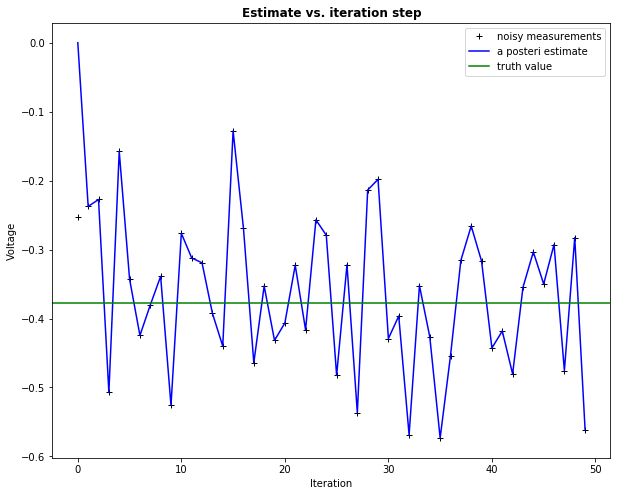

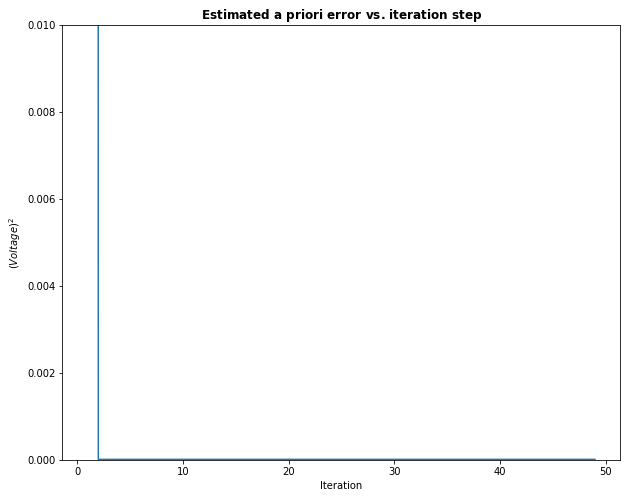

In [62]:
plt.figure()
plt.plot(z,'k+',label='noisy measurements')
plt.plot(xhat,'b-',label='a posteri estimate')
plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')

plt.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('$(Voltage)^2$')
plt.setp(plt.gca(),'ylim',[0,.01])
plt.show()

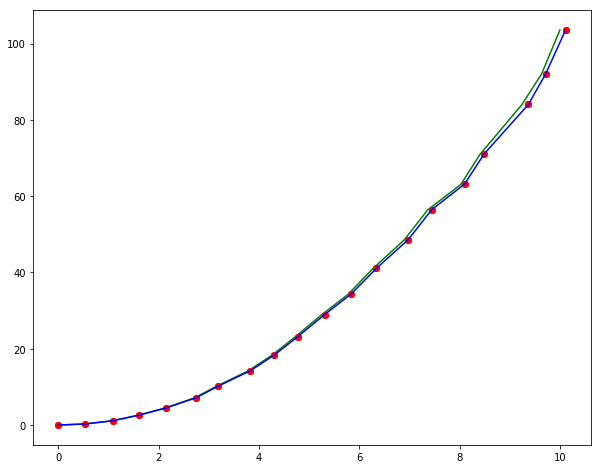

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def kalman_xy(x, P, measurement, R,
              motion = np.matrix('0. 0.').T,
              Q = np.matrix(np.eye(2))):
    """
    Parameters:    
    x: initial state 4-tuple of location and velocity: (x0, x1, x0_dot, x1_dot)
    P: initial uncertainty convariance matrix
    measurement: observed position
    R: measurement noise 
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    """
    return kalman(x, P, measurement, R, motion, Q,
                  F = np.matrix('''
                      1. 0.;
                      0. 1.
                      '''),
                  H = np.matrix('''
                      1. 0.;
                      0. 1.'''))

def kalman(x, P, measurement, R, motion, Q, F, H):
    '''
    Parameters:
    x: initial state
    P: initial uncertainty convariance matrix
    measurement: observed position (same shape as H*x)
    R: measurement noise (same shape as H)
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    F: next state function: x_prime = F*x
    H: measurement function: position = H*x

    Return: the updated and predicted new values for (x, P)

    See also http://en.wikipedia.org/wiki/Kalman_filter

    This version of kalman can be applied to many different situations by
    appropriately defining F and H 
    '''
    # UPDATE x, P based on measurement m    
    # distance between measured and current position-belief
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R  # residual convariance
    K = P * H.T * S.I    # Kalman gain
    x = x + K*y
    I = np.matrix(np.eye(F.shape[0])) # identity matrix
    P = (I - K*H)*P

    # PREDICT x, P based on motion
    x = F*x + motion
    P = F*P*F.T + Q

    return x, P

def demo_kalman_xy():
    x = np.matrix('0. 0.').T 
    P = np.matrix(np.eye(2))*1000 # initial uncertainty

    N = 20
    true_x = np.linspace(0.0, 10.0, N)
    true_y = true_x**2
    observed_x = true_x + 0.05*np.random.random(N)*true_x
    observed_y = true_y + 0.05*np.random.random(N)*true_y
    plt.plot(observed_x, observed_y, 'ro')
    result = []
    result2 = []
    R = 0.01**1
    for meas in zip(observed_x, observed_y):
        x, P = kalman_xy(x, P, meas, R)
        result.append((x).tolist())
    kalman_x, kalman_y = zip(*result)
    plt.plot(kalman_x, kalman_y, 'g-')
#     plt.show()
    
    R = 0.01**10
    for meas in zip(observed_x, observed_y):
        x, P = kalman_xy(x, P, meas, R)
        result2.append((x).tolist())
    kalman_x, kalman_y = zip(*result2)
    plt.plot(observed_x, observed_y, 'ro')
    plt.plot(kalman_x, kalman_y, 'b-')
    
    plt.show()

demo_kalman_xy()

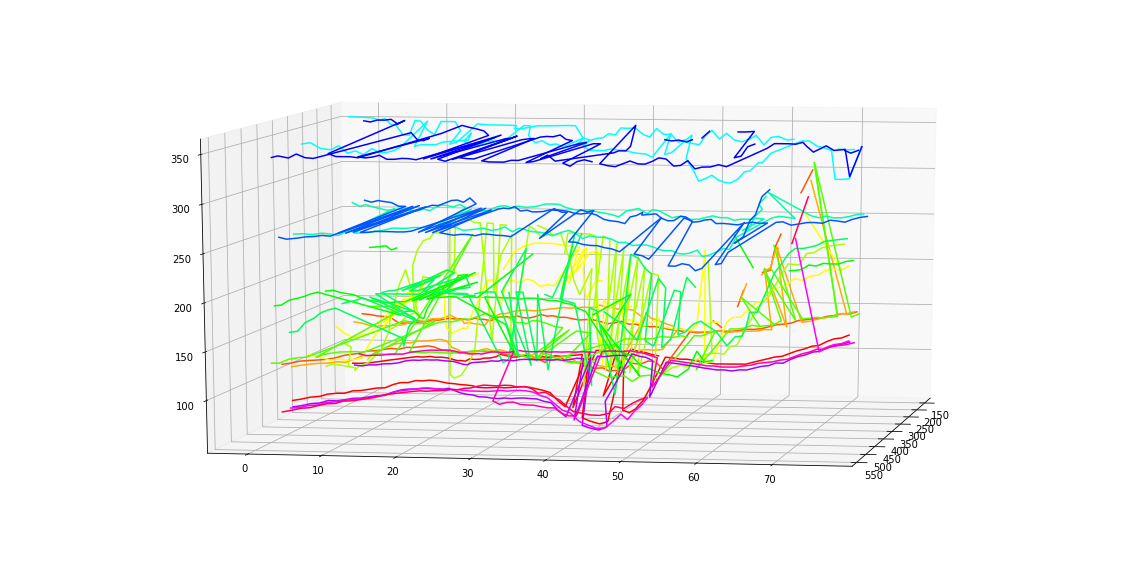

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

subset = np.load('subset.npy').item()
candidate = np.load('candidate.npy').item()
all_peaks = np.load('all_peaks.npy').item()

plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

frames = np.arange(76)
frame_num = 76
part_num = 18
person_num = 2

pose_flow = np.zeros([part_num, person_num, frame_num, 2])

for part in range(part_num):
    for frame in range(frame_num):
        if len(all_peaks[frame][part])>person_num:
            top_person_num = np.asarray(map(lambda x: x[3], all_peaks[frame][part])).argsort()[-person_num:][::-1]
            for person in range(person_num):
                pose_flow[part][person][frame] = all_peaks[frame][part][top_person_num[person]][:2]
        elif len(all_peaks[frame][part])==person_num:
            for person in range(person_num):
                pose_flow[part][person][frame] = all_peaks[frame][part][person][:2]
        elif len(all_peaks[frame][part]) == 0:
            for person in range(person_num):
                pose_flow[part][person][frame] = np.empty([1,2])*np.nan
        else:
            for person_ap in range(len(all_peaks[frame][part])):
                pose_flow[part][person_ap][frame] = all_peaks[frame][part][person_ap][:2]
            for rest in range(len(all_peaks[frame][part]),person_num):
                pose_flow[part][rest][frame] = np.empty([1,2])*np.nan
     

    
    
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
colors = [[color[0]/255.0, color[1]/255.0, color[2]/255.0] for color in colors]

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 1, 1]))

for part in np.arange(0,18):
    for person in range(person_num):
        ax.plot(pose_flow[part][person][:,0], frames, pose_flow[part][person][:,1], color=colors[part])
ax.view_init(10, 10)
plt.show()

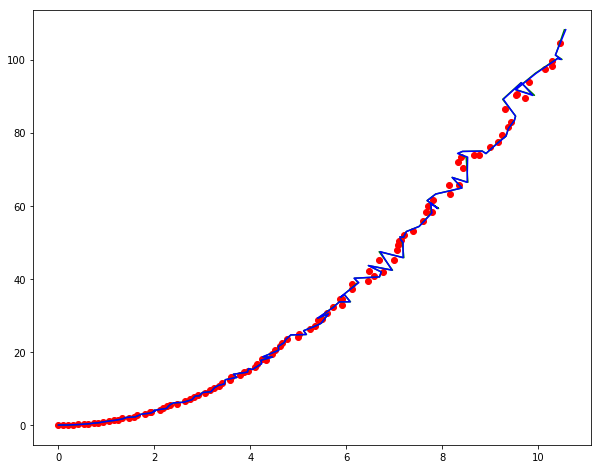

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def kalman_xy(x, P, measurement, R,
              motion = np.matrix('0. 0. 0. 0.').T,
              Q = np.matrix(np.eye(4))):
    """
    Parameters:    
    x: initial state 4-tuple of location and velocity: (x0, x1, x0_dot, x1_dot)
    P: initial uncertainty convariance matrix
    measurement: observed position
    R: measurement noise 
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    """
    return kalman(x, P, measurement, R, motion, Q,
                  F = np.matrix('''
                      1. 0. 1. 0.;
                      0. 1. 0. 1.;
                      0. 0. 1. 0.;
                      0. 0. 0. 1.
                      '''),
                  H = np.matrix('''
                      1. 0. 0. 0.;
                      0. 1. 0. 0.'''))

def kalman(x, P, measurement, R, motion, Q, F, H):
    '''
    Parameters:
    x: initial state
    P: initial uncertainty convariance matrix
    measurement: observed position (same shape as H*x)
    R: measurement noise (same shape as H)
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    F: next state function: x_prime = F*x
    H: measurement function: position = H*x

    Return: the updated and predicted new values for (x, P)

    See also http://en.wikipedia.org/wiki/Kalman_filter

    This version of kalman can be applied to many different situations by
    appropriately defining F and H 
    '''
    # UPDATE x, P based on measurement m    
    # distance between measured and current position-belief
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R  # residual convariance
    K = P * H.T * S.I    # Kalman gain
    x = x + K*y
    I = np.matrix(np.eye(F.shape[0])) # identity matrix
    P = (I - K*H)*P

    # PREDICT x, P based on motion
    x = F*x + motion
    P = F*P*F.T + Q

    return x, P

def demo_kalman_xy():
    x = np.matrix('0. 0. 0. 0.').T 
    P = np.matrix(np.eye(4))*1000 # initial uncertainty

    N = 100
    true_x = np.linspace(0.0, 10.0, N)
    true_y = true_x**2
    observed_x = true_x + 0.05*np.random.random(N)*true_x
    observed_y = true_y + 0.05*np.random.random(N)*true_y
    plt.plot(observed_x, observed_y, 'ro')
    result = []
    result2 = []
    R = 0.01**1
    for meas in zip(observed_x, observed_y):
        x, P = kalman_xy(x, P, meas, R)
        result.append((x[:2]).tolist())
        
    x = np.matrix('0. 0. 0. 0.').T 
    P = np.matrix(np.eye(4))*1000 # initial uncertainty
    R = 0.01**10
    for meas in zip(observed_x, observed_y):
        x, P = kalman_xy(x, P, meas, R)
        result2.append((x[:2]).tolist())
    kalman_x, kalman_y = zip(*result)
    plt.plot(kalman_x, kalman_y, 'g-')
    kalman_x2, kalman_y2 = zip(*result2)
    plt.plot(kalman_x2, kalman_y2, 'b-')
    plt.show()
#     print result
#     print result2

demo_kalman_xy()

[9, 8, 12, 11, 10, 13, 14, 15, 2, 1, 0, 3, 4, 5]


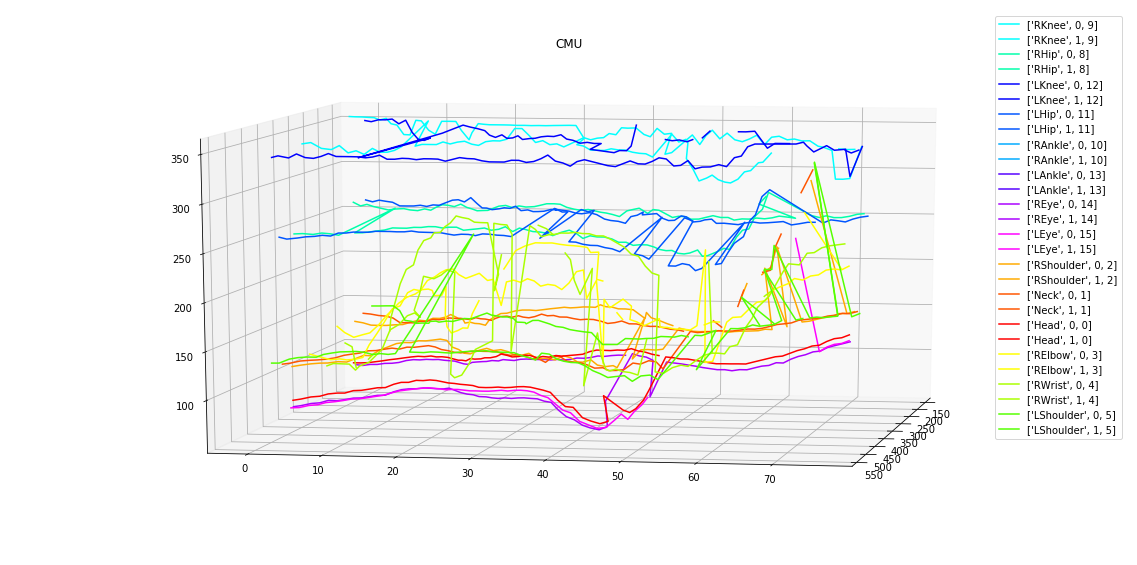

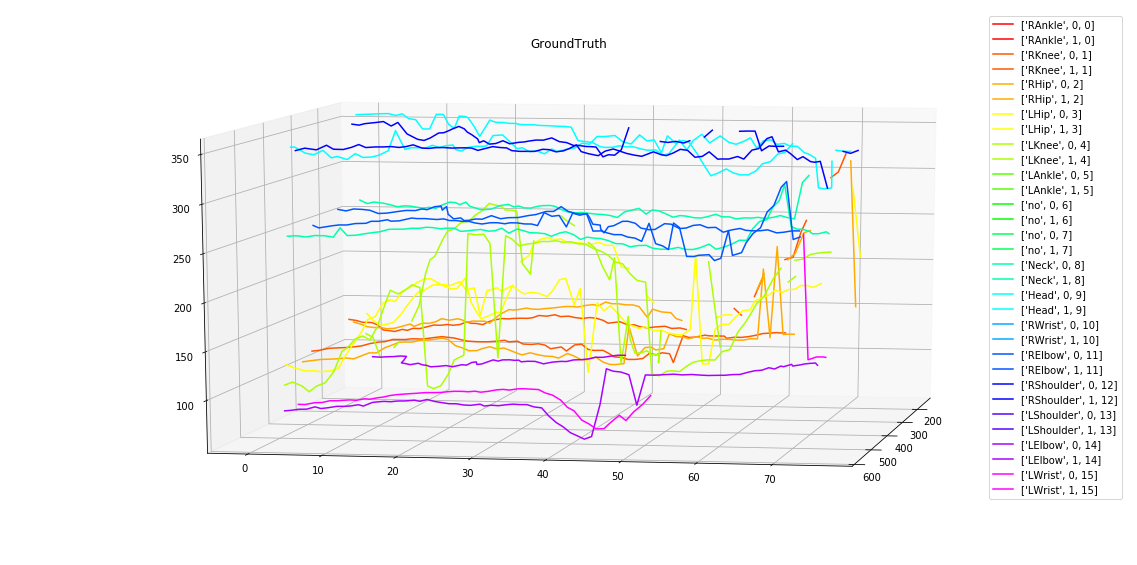

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io

subset = np.load('subset.npy').item()
candidate = np.load('candidate.npy').item()
all_peaks = np.load('all_peaks.npy').item()


frames = np.arange(76)
frame_num = 76
part_num = 18
person_num = 2

pose_flow = np.zeros([part_num, person_num, frame_num, 2])

for part in range(part_num):
    for frame in range(frame_num):
        if len(all_peaks[frame][part])>person_num:
            top_person_num = np.asarray(map(lambda x: x[3], all_peaks[frame][part])).argsort()[-person_num:][::-1]
            top_person_num = np.asarray(map(lambda x: x[3], all_peaks[frame][part])).argsort()[-person_num:][::-1]
            for person in range(person_num):
                pose_flow[part][person][frame] = all_peaks[frame][part][top_person_num[person]][:2]
        elif len(all_peaks[frame][part])==person_num:
            for person in range(person_num):
                pose_flow[part][person][frame] = all_peaks[frame][part][person][:2]
        elif len(all_peaks[frame][part]) == 0:
            for person in range(person_num):
                pose_flow[part][person][frame] = np.empty([1,2])*np.nan
        else:
            for person_ap in range(len(all_peaks[frame][part])):
                pose_flow[part][person_ap][frame] = all_peaks[frame][part][person_ap][:2]
            for rest in range(len(all_peaks[frame][part]),person_num):
                pose_flow[part][rest][frame] = np.empty([1,2])*np.nan

def dis(a,b):
    return (a[0]-b[0])**2+(a[1]-b[1])**2

for frame in range(frame_num):
    for part in range(part_num):
        if frame > 0:
            dis_0_up = dis(pose_flow[part][0][frame], pose_flow[part][0][frame-1])
            dis_1_up = dis(pose_flow[part][1][frame], pose_flow[part][1][frame-1])
            dis_0_right = dis(pose_flow[part][0][frame], pose_flow[part][1][frame-1])
            dis_1_left = dis(pose_flow[part][1][frame], pose_flow[part][0][frame-1])
            if dis_0_up>dis_0_right and dis_1_up>dis_1_left:
                tmp = pose_flow[part][1][frame].copy()
                pose_flow[part][1][frame] = pose_flow[part][0][frame].copy()
                pose_flow[part][0][frame] = tmp.copy()
                

gt_part_names = ['RAnkle','RKnee','RHip','LHip','LKnee','LAnkle','no','no','Neck','Head','RWrist','RElbow','RShoulder',\
                'LShoulder','LElbow','LWrist']   

part_names = ['Head','Neck','RShoulder','RElbow','RWrist','LShoulder','LElbow','LWrist','RHip','RKnee','RAnkle','LHip',\
             'LKnee','LAnkle','REye','LEye','REar','LEar']  

cor_color_id = np.zeros([14,])
for part_id in range(len(part_names[:14])):
    cor_color_id[part_id] = gt_part_names.index(part_names[part_id])   
cor_color_id = [int(item) for item in cor_color_id]

print cor_color_id

colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
colors = [[color[0]/255.0, color[1]/255.0, color[2]/255.0] for color in colors]

choose_part = True
plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

if not choose_part:
    for part in np.arange(0,18):
        for person in range(person_num):
            ax.plot(pose_flow[part][person][:,0], frames, pose_flow[part][person][:,1],  color=colors[part],label=[part_names[part],person,part])
else:
    for part in cor_color_id:
        for person in range(person_num):
            ax.plot(pose_flow[part][person][:,0], frames, pose_flow[part][person][:,1],color=colors[part], label=[part_names[part],person,part])

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 1, 1]))
ax.view_init(10, 10)
ax.legend()    
plt.title('CMU')

mat_file = '/home/yuliang/dataset/posetrack/MultiPerson_PoseTrack_v0.1/MultiPerson_PoseTrack_v0.1.mat'
gt_posetrack = scipy.io.loadmat(mat_file)['RELEASE']
gt_one = gt_posetrack['annolist'][0,0]['annopoints'][0,0]

part_num_gt = 16
pose_flow_gt = np.zeros([part_num, person_num, frame_num, 2])

for frame in range(frame_num):
    for person in range(person_num):
        part_list = np.hstack(gt_one[person][frame][0,0]['point'][0]['id'][:])[0]
        for part_th in range(len(part_list)):
            pose_flow_gt[part_list[part_th]][person][frame][0] = gt_one[person][frame][0,0]['point'][0]['x'][part_th][0,0]
            pose_flow_gt[part_list[part_th]][person][frame][1] = gt_one[person][frame][0,0]['point'][0]['y'][part_th][0,0]

pose_flow_gt[pose_flow_gt==0] = np.nan

choose_part = False
plt.figure(figsize=(20,10))
ax2 = plt.axes(projection='3d')

if not choose_part:
    for part in np.arange(0,part_num_gt):
        for person in range(person_num):
            ax2.plot(pose_flow_gt[part][person][:,0], frames, pose_flow[part][person][:,1],  color=colors[part],label=[gt_part_names[part],person,part])
else:
    for part in np.arange(5,8):
        for person in range(person_num):
            ax2.plot(pose_flow_gt[part][person][:,0], frames, pose_flow[part][person][:,1],label=[gt_part_names[part],person,part])

ax2.get_proj = lambda: np.dot(Axes3D.get_proj(ax2), np.diag([1, 1, 1, 1]))
ax2.view_init(10, 10)
ax2.legend()
plt.title('GroundTruth')

plt.show()